# Project
: 단변량 시계열 중 추세(trend)가 바뀌는 경우 예측하기가 까다롭다.<br>
원하는 데이터가 없는 경우 change point 설정을 통해 변하는 추세를 고려한 단변량 시계열 예측을 시도해 보려함<br>

데이터: 상하이항 화물 데이터를 직접 크롤링을 통해 수집<br>
예측기간: 코로나 이후 2022년 1월 ~ 2023년 2월 예측<br>
프로젝트 의의: 시계열 데이터의 최근 추세 변화를 활용하여 예측 시도해보려함

In [7]:
# pip install sktime

In [8]:
# pip install feature_engine

In [9]:
# pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_context('talk')
warnings.filterwarnings('ignore')

# Data

In [13]:
df = pd.read_csv('SIGP_freight_data.csv',index_col=0, parse_dates=True)
df

,cargo,container
2007-01-31,2828.2,204.7
2007-02-28,2512.5,181.0
2007-03-31,2850.2,202.8
2007-04-30,3027.7,220.1
2007-05-31,3139.4,220.8
...,...,...
2022-10-31,4394.4,419.4
2022-11-30,4529.5,411.0
2022-12-31,4566.1,410.9
2023-01-31,4304.7,380.3


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 194 entries, 2007-01-31 to 2023-02-28
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cargo      194 non-null    float64
 1   container  194 non-null    float64
dtypes: float64(2)
memory usage: 4.5 KB


## train test split
train valid test 로 나눠 검증하고 싶지만 추세가 일정하지 않아 검증에 의미가 적음

In [15]:
df_total = df[['cargo']].copy()
years = df_total.index.year
df_train = df_total.loc[years<=2021].copy()
df_test = df_total.loc[years>=2022].copy()

 # Data Analysis

## visualtization

In [16]:
df_train['cargo']

2007-01-31    2828.2
2007-02-28    2512.5
2007-03-31    2850.2
2007-04-30    3027.7
2007-05-31    3139.4
               ...  
2021-08-31    4985.8
2021-09-30    4303.8
2021-10-31    4617.2
2021-11-30    4420.3
2021-12-31    4373.0
Name: cargo, Length: 180, dtype: float64

Text(0.5, 1.0, 'Shanghai_Cargo')

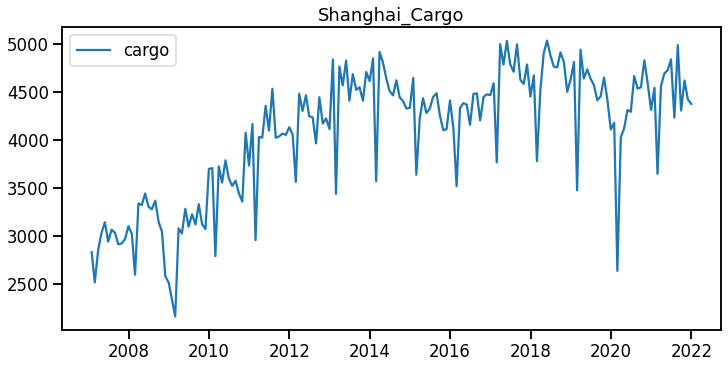

In [18]:
fig,ax = plt.subplots(figsize=(10,5), constrained_layout=True)
ax.plot(df_train.index, df_train['cargo'],label='cargo')
ax.legend()
ax.set_title('Shanghai_Cargo')

## Stationary
ADF test<br>
H0: Non stationary exists in the series<br>
H1: Stationary exists in the series

In [19]:
from statsmodels.tsa.stattools import adfuller
res = adfuller(df_train['cargo'])
print(f"Statistic: {res[0]}")
print(f"p-value: {res[1]}")
print(f"1%: ", res[4]["1%"] )
print(f"5%: ", res[4]["5%"])
print(f"10%: ",res[4]["10%"] )


Statistic: -2.0271369485860498
p-value: 0.2748026856877359
1%:  -3.4703698981001665
5%:  -2.8791138497902193
10%:  -2.576139407751488


## Seasonailty

### EDA: 월별 계절성을 확인

In [20]:
df_train.head()

,cargo
2007-01-31,2828.2
2007-02-28,2512.5
2007-03-31,2850.2
2007-04-30,3027.7
2007-05-31,3139.4


In [21]:
df_train.index.max()

Timestamp('2021-12-31 00:00:00')

In [22]:
df_train['month'] = df_train.index.month

#### box_plot

<Axes: ylabel='cargo'>

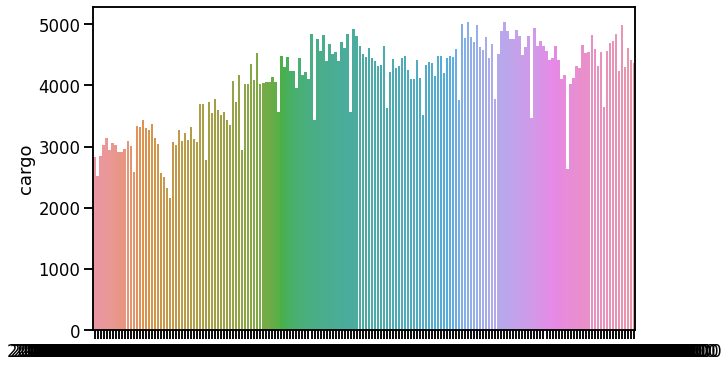

In [23]:
fig, ax = plt.subplots(figsize=(10,5),constrained_layout=True)
sns.barplot(data=df_train, x=df_train.index, y='cargo')

(2000.0, 5000.0)

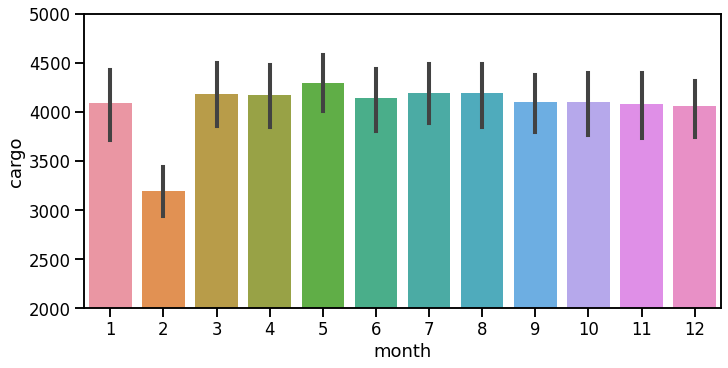

In [24]:
# 2월달에 하락 급격히 하락하는 모습을 보임
fig, ax = plt.subplots(figsize=(10,5),constrained_layout=True)
sns.barplot(data=df_train, x='month', y='cargo',ax=ax)
ax.set_ylim([2000,5000])

#### line plot

In [25]:
df_train.head()

,cargo,month
2007-01-31,2828.2,1
2007-02-28,2512.5,2
2007-03-31,2850.2,3
2007-04-30,3027.7,4
2007-05-31,3139.4,5


Text(0, 0.5, 'Cargo')

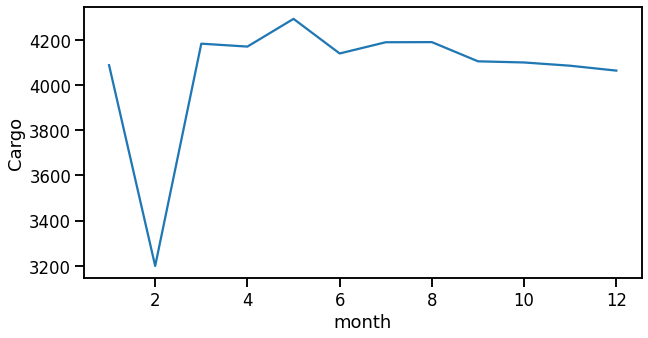

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
df_train.groupby("month")['cargo'].mean().plot(ax=ax)
plt.xlabel("month")
plt.ylabel("Cargo")

In [27]:
df_train['year'] = df_train.index.year
df_train.head()

,cargo,month,year
2007-01-31,2828.2,1,2007
2007-02-28,2512.5,2,2007
2007-03-31,2850.2,3,2007
2007-04-30,3027.7,4,2007
2007-05-31,3139.4,5,2007


<Axes: xlabel='month', ylabel='cargo'>

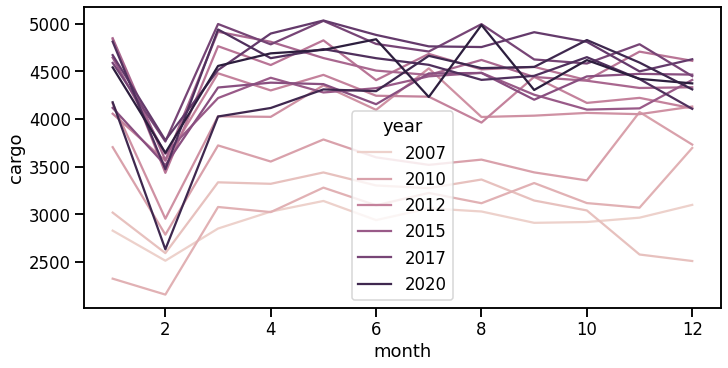

In [28]:
fig, ax = plt.subplots(figsize=(10,5),constrained_layout=True)
sns.lineplot(data=df_train, x='month', y='cargo', hue='year')

In [29]:
df_train.pivot(index=["month"],columns=["year"])['cargo']

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
month,,,,,,,,,,,,,,,
1,2828.2,3017.4,2324.2,3703.8,4163.2,4054.7,4836.4,4846.6,4643.6,4116.2,4587.9,4669.6,4810.7,4175.0,4540.8
2,2512.5,2592.2,2157.0,2786.0,2953.2,3560.8,3434.3,3567.0,3634.4,3514.6,3763.0,3776.6,3472.1,2631.9,3644.3
3,2850.2,3335.0,3076.2,3722.1,4027.6,4478.9,4763.2,4914.4,4219.1,4329.8,4995.9,4512.9,4938.6,4025.6,4556.2
4,3027.7,3319.4,3022.6,3553.0,4021.9,4299.2,4565.7,4809.5,4432.0,4380.6,4782.6,4896.2,4637.8,4115.0,4688.2
5,3139.4,3438.6,3279.3,3784.5,4351.8,4462.3,4824.5,4638.9,4277.8,4365.2,5029.5,5032.8,4732.4,4309.6,4724.7
6,2938.4,3301.8,3093.6,3597.1,4095.5,4243.5,4406.7,4507.3,4322.6,4154.5,4787.2,4881.5,4637.3,4291.6,4836.1
7,3062.2,3273.8,3223.6,3518.1,4530.9,4233.5,4682.6,4461.6,4447.1,4477.6,4707.4,4761.4,4567.8,4662.2,4230.3
8,3029.0,3364.5,3115.8,3573.2,4020.5,3961.7,4519.9,4618.9,4484.0,4482.3,4994.7,4754.4,4409.9,4533.3,4985.8
9,2909.9,3144.0,3327.5,3439.3,4034.4,4441.7,4546.4,4440.3,4254.0,4201.7,4624.2,4910.0,4452.3,4545.4,4303.8


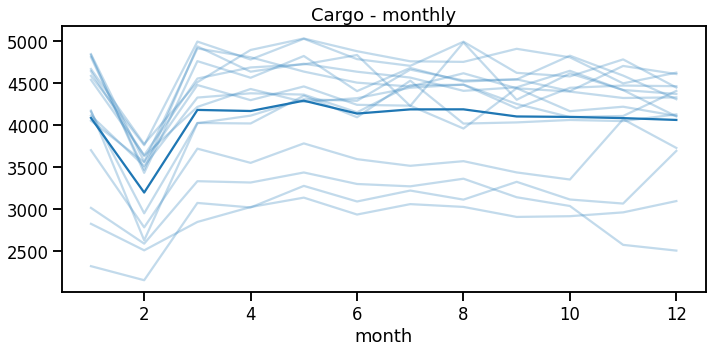

In [30]:
cmap = sns.color_palette("Blues", n_colors=5)

# 전체 데이터 월별 흐름 
fig, ax = plt.subplots(figsize=[10, 5])
(
    df_train.pivot(index=["month"], columns=["year"])['cargo'].plot(
        legend=False, alpha=0.3, color=cmap[3], ax=ax
    )
)

# 평균선
(df_train.groupby("month").mean(numeric_only=True)['cargo'].plot(ax=ax))

ax.set_title("Cargo - monthly")

plt.tight_layout()

### Detrend

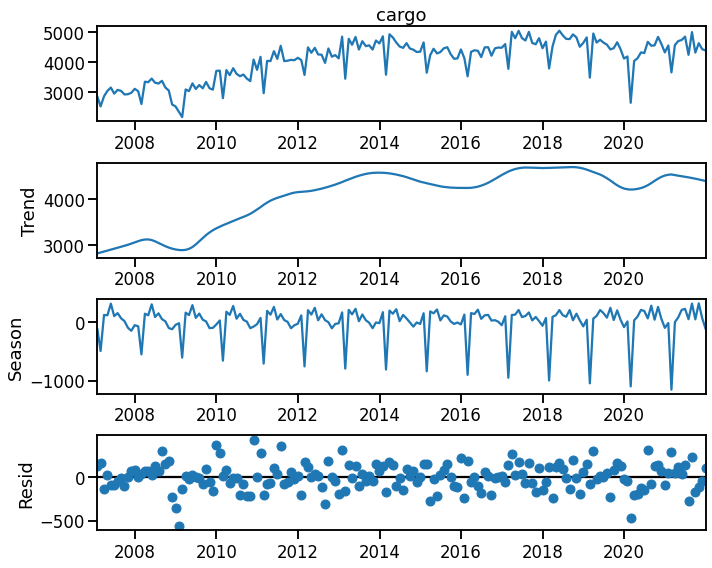

In [31]:
# Trend 가 존재하므로 Trend 제외 이후 분석
# STL 사용하여 추세제거
from statsmodels.tsa.seasonal import STL
stl = STL(df_train['cargo'],seasonal=13)
res = stl.fit()

plt.rc("figure", figsize=(10,8))
fig = res.plot()

### AutoCorrelation

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

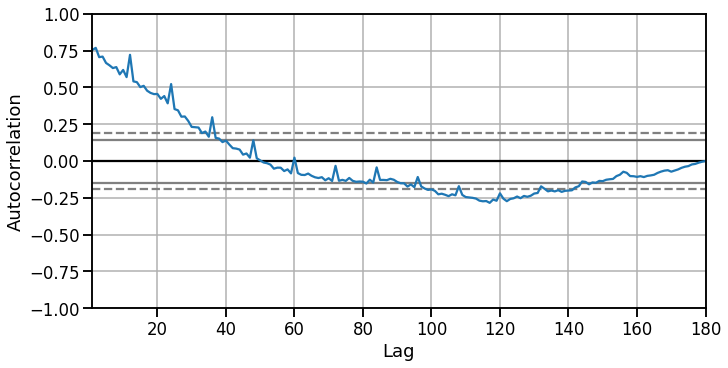

In [32]:
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
pd.plotting.autocorrelation_plot(df_train['cargo'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

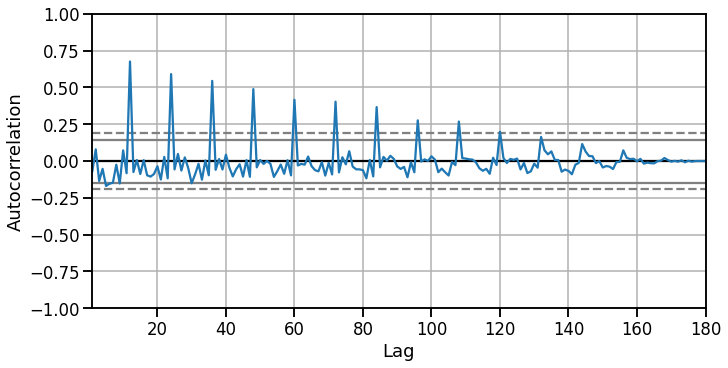

In [33]:
# detrend autocorrelation plot
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
detrend = res.seasonal + res.resid
pd.plotting.autocorrelation_plot(detrend)

(<matplotlib.patches.Rectangle at 0x1c48eaa32b0>,
 (<matplotlib.patches.ConnectionPatch at 0x1c48ed72da0>,
  <matplotlib.patches.ConnectionPatch at 0x1c48ed73520>))

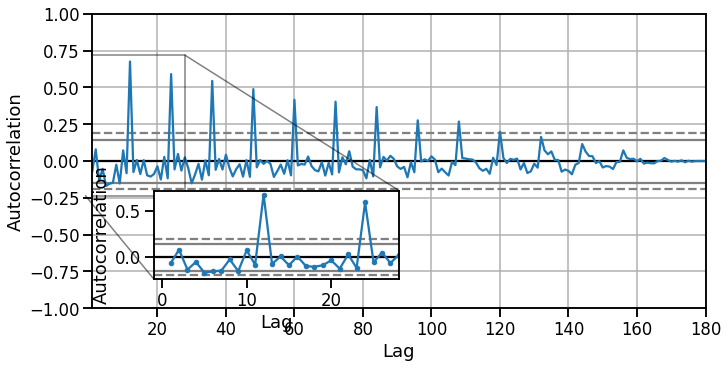

In [34]:
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
detrend = res.seasonal + res.resid
pd.plotting.autocorrelation_plot(detrend)
# 확대
ax_in = ax.inset_axes([0.1,0.1,0.4,0.3])
pd.plotting.autocorrelation_plot(detrend,ax=ax_in,marker='.')
ax_in.set_xlim(-1,28)
ax_in.grid(False)

# 확대부분
ax.indicate_inset_zoom(ax_in,edgecolor='k')

# Feature extraction
데이터가 많다면 df_train, df_test 에서 각각 feature extraction을 해줘야하지만<br>
데이터 수가 적은 관계로 df_total로 feature를 만든 이후 날짜별로 train,test셋을 나눠줌<br>
(test 데이터에서 lag_feature로 인해 최근 12개월 데이터가 사라지는 것을 방지하기 위함)

In [35]:
df_total = df[['cargo']].copy()

## Date feature

In [36]:
# month
df_total['month'] = df_total.index.month

## cyclical feature
월(1~12월)을 연속된 순환 feature로 변환 

In [37]:
df_total['month_sin'] = df_total['month'].apply(lambda x: np.sin(x/12 * 2*np.pi))
df_total['month_cos'] = df_total['month'].apply(lambda x: np.cos(x/12 * 2*np.pi))

# 기존 month 삭제
df_total.drop(columns='month',inplace=True)

## lag feature
train데이터에서 추출

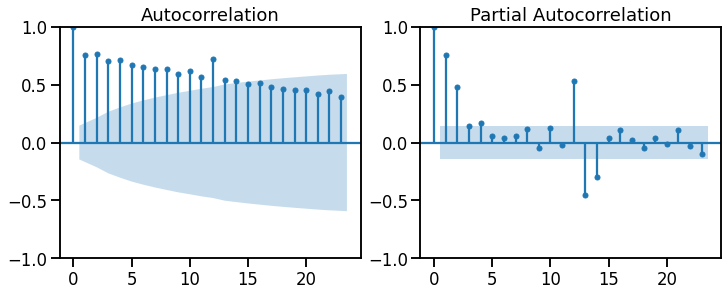

In [38]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig, axs = plt.subplots(ncols=2,figsize=(10,4),constrained_layout=True)
acf = plot_acf(df_train['cargo'],ax=axs[0])
pacf = plot_pacf(df_train['cargo'],ax=axs[1])

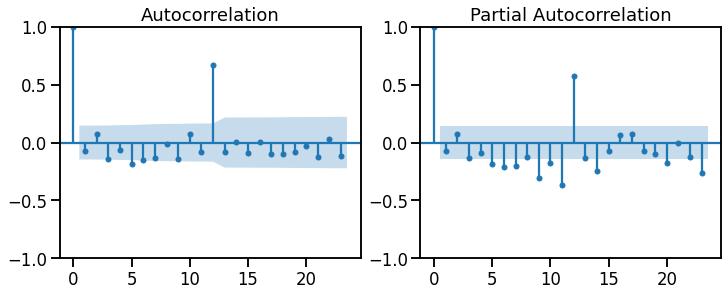

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

# detrend
res = seasonal_decompose(df_train['cargo'],extrapolate_trend=True)

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig, axs = plt.subplots(ncols=2,figsize=(10,4),constrained_layout=True)
acf = plot_acf(res.seasonal+res.resid,ax=axs[0])
pacf = plot_pacf(res.seasonal+res.resid,ax=axs[1])

In [40]:
lags = [1,2,4,12]
for lag in lags:
    df_total[f"lag_{lag}"] = df_total['cargo'].shift(lag)
    
# Nan값 제거
df_total = df_total.dropna()

In [41]:
df_total

,cargo,month_sin,month_cos,lag_1,lag_2,lag_4,lag_12
2008-01-31,3017.4,5.000000e-01,8.660254e-01,3098.5,2964.1,2909.9,2828.2
2008-02-29,2592.2,8.660254e-01,5.000000e-01,3017.4,3098.5,2918.6,2512.5
2008-03-31,3335.0,1.000000e+00,6.123234e-17,2592.2,3017.4,2964.1,2850.2
2008-04-30,3319.4,8.660254e-01,-5.000000e-01,3335.0,2592.2,3098.5,3027.7
2008-05-31,3438.6,5.000000e-01,-8.660254e-01,3319.4,3335.0,3017.4,3139.4
...,...,...,...,...,...,...,...
2022-10-31,4394.4,-8.660254e-01,5.000000e-01,4194.7,4566.3,4017.0,4617.2
2022-11-30,4529.5,-5.000000e-01,8.660254e-01,4394.4,4194.7,4810.2,4420.3
2022-12-31,4566.1,-2.449294e-16,1.000000e+00,4529.5,4394.4,4566.3,4373.0
2023-01-31,4304.7,5.000000e-01,8.660254e-01,4566.1,4529.5,4194.7,4773.4


## pipeline

In [42]:
from sklearn.pipeline import Pipeline
from feature_engine.timeseries.forecasting import LagFeatures 
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.imputation import DropMissingData

lag_tf = LagFeatures(variables=['cargo'],
                    freq=[f'{i}M' for i in [1,2,4,12]])

date_tf = DatetimeFeatures(variables='index',
                        features_to_extract=['month'],
                          drop_original=True)

cyclic_tf = CyclicalFeatures(variables=['month'])

dropna = DropMissingData()

In [43]:
pipeline_1step = Pipeline([
    ("date_tf", date_tf),
    ("cyclic_tf", cyclic_tf),
    ("lag_tf", lag_tf),
    ("dropna", dropna)
])

## train test split

In [44]:
years = df_total.index.year
df_train = df_total.loc[years<=2021]
df_test = df_total.loc[years>=2022]

X_train = df_train.drop(columns='cargo').copy()
y_train = df_train['cargo']

X_test = df_test.drop(columns='cargo').copy()
y_test = df_test['cargo']

In [45]:
# pipeline
pipeline_1step.fit_transform(df_train)

,cargo,month_sin,month_cos,lag_1,lag_2,lag_4,lag_12,month,cargo_lag_1M,cargo_lag_2M,cargo_lag_4M,cargo_lag_12M
2009-01-31,2324.2,5.000000e-01,8.660254e-01,2509.3,2577.6,3144.0,3017.4,1,2509.3,2577.6,3144.0,3017.4
2009-02-28,2157.0,8.660254e-01,5.000000e-01,2324.2,2509.3,3040.0,2592.2,2,2324.2,2509.3,3040.0,2592.2
2009-03-31,3076.2,1.000000e+00,6.123234e-17,2157.0,2324.2,2577.6,3335.0,3,2157.0,2324.2,2577.6,3335.0
2009-04-30,3022.6,8.660254e-01,-5.000000e-01,3076.2,2157.0,2509.3,3319.4,4,3076.2,2157.0,2509.3,3319.4
2009-05-31,3279.3,5.000000e-01,-8.660254e-01,3022.6,3076.2,2324.2,3438.6,5,3022.6,3076.2,2324.2,3438.6
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,4985.8,-8.660254e-01,-5.000000e-01,4230.3,4836.1,4688.2,4533.3,8,4230.3,4836.1,4688.2,4533.3
2021-09-30,4303.8,-1.000000e+00,-1.836970e-16,4985.8,4230.3,4724.7,4545.4,9,4985.8,4230.3,4724.7,4545.4
2021-10-31,4617.2,-8.660254e-01,5.000000e-01,4303.8,4985.8,4836.1,4828.0,10,4303.8,4985.8,4836.1,4828.0
2021-11-30,4420.3,-5.000000e-01,8.660254e-01,4617.2,4303.8,4230.3,4591.4,11,4617.2,4303.8,4230.3,4591.4


# Modeling1: 추세가 지금과 비슷할 경우
2020년 1월 코로나 이후 2021년까지 화물량이 증가하는 추세를 보이고 있음<br>
2021년 기준으로 2022년,2023년 전망을 예측해야함

## train visualization

Text(0.5, 1.0, 'Shanghai_Cargo')

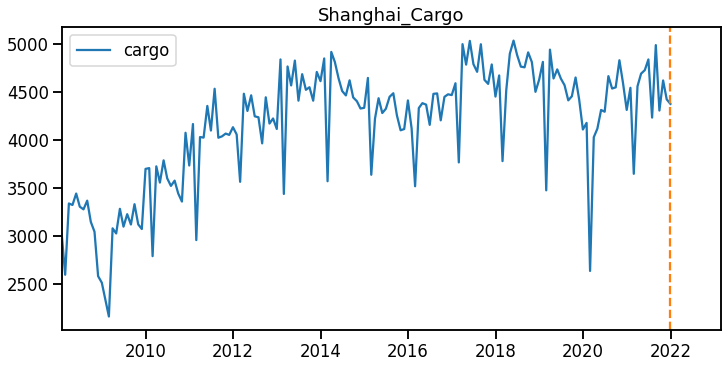

In [46]:
fig,ax = plt.subplots(figsize=(10,5), constrained_layout=True)
ax.plot(df_train.index, df_train['cargo'],label='cargo')
ax.axvline(x=df_train.index[-1],ls='--', color='C1')
ax.set_xlim((df_total.index[0],df_total.index[-1]))
ax.legend()
ax.set_title('Shanghai_Cargo')

## 다음달 예측(1step)

### Linear regression

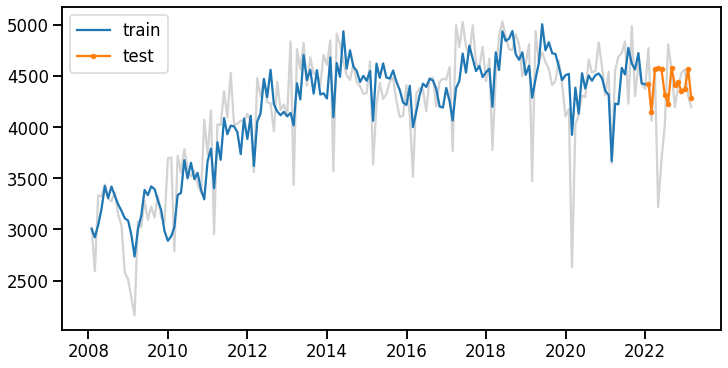

In [47]:
# linear regression
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train,y_train)

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

fig, ax = plt.subplots(figsize=(10,5),constrained_layout=True)
ax.plot(df_total.index, df_total['cargo'], c='lightgray')
ax.plot(df_train.index, train_preds, label='train')
ax.plot(df_test.index, test_preds, label='test',marker='.')
ax.legend()

### RandomForest

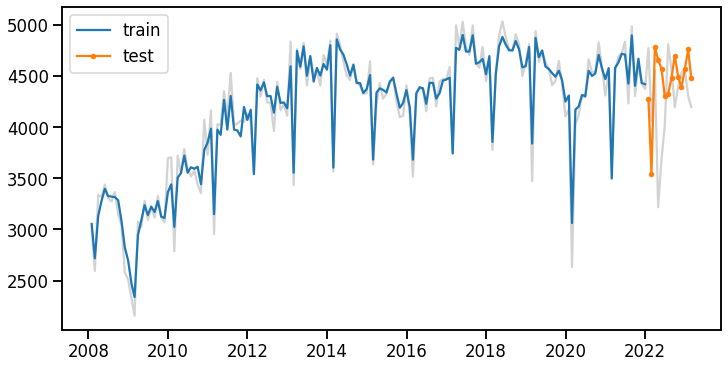

In [48]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor() # 외삽(extrapolation) 문제가 있음
model.fit(X_train,y_train)

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

fig, ax = plt.subplots(figsize=(10,5),constrained_layout=True)
ax.plot(df_total.index, df_total['cargo'], c='lightgray')
ax.plot(df_train.index, train_preds, label='train')
ax.plot(df_test.index, test_preds, label='test',marker='.')
ax.legend()

## 1년(12달) 예측: linear regression

In [ ]:
# 예측할 기간 14
predict_num = len(df_test)

# 예측 시작 
forecast_start = df_test.index[0]

# 예측기간
forecast_range = pd.date_range(start=forecast_start, periods=predict_num, freq='MS')

# 모델
model = LinearRegression()




# Trend Feature: trend 변화 고려

Text(0.5, 1.0, 'Shanghai_Cargo')

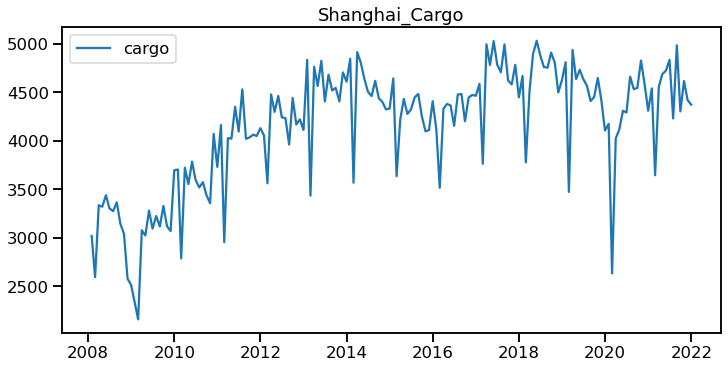

In [68]:
fig,ax = plt.subplots(figsize=(10,5), constrained_layout=True)
ax.plot(df_train.index, df_train['cargo'],label='cargo')
ax.legend()
ax.set_title('Shanghai_Cargo')

## Trend extraction

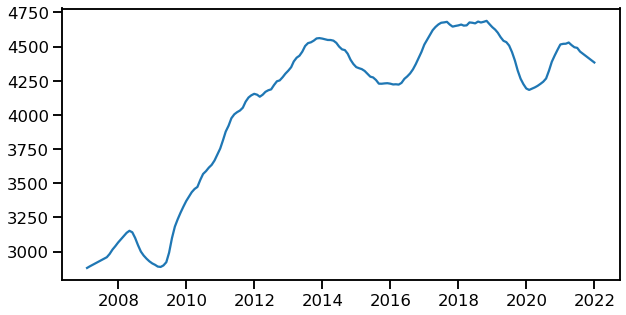

In [69]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res.trend.index, res.trend)

## Trial1: Lowess 
세세한 트랜드 스무딩을 위해 lowess 사용<br>
trend 를 뽑아 local min, local max 를 사용하여 trend가 변하는 날짜를 찾을 예정<br>
뽑힌 trend에서 local min, local max가 정확하게 뽑아질 수 있는지 여부가 중요<br>

In [70]:
# frac = 0.1
from statsmodels.nonparametric.smoothers_lowess import lowess
y = df_train['cargo']
x = np.arange(0,len(y))
frac = 0.1
res = lowess(
        endog=y,
        exog=x,
        frac = frac,
        it=3)
res[:10]

array([[0.00000000e+00, 3.32575999e+03],
       [1.00000000e+00, 3.31616700e+03],
       [2.00000000e+00, 3.30308974e+03],
       [3.00000000e+00, 3.28707186e+03],
       [4.00000000e+00, 3.26833683e+03],
       [5.00000000e+00, 3.24609118e+03],
       [6.00000000e+00, 3.21649767e+03],
       [7.00000000e+00, 3.16958749e+03],
       [8.00000000e+00, 3.12338606e+03],
       [9.00000000e+00, 3.10454425e+03]])

In [71]:
df_train['lowess'] = res[:,1]
df_train.head()

,cargo,month_sin,month_cos,lag_1,lag_2,lag_4,lag_12,lowess
2008-01-31,3017.4,0.500000,8.660254e-01,3098.5,2964.1,2909.9,2828.2,3325.759991
2008-02-29,2592.2,0.866025,5.000000e-01,3017.4,3098.5,2918.6,2512.5,3316.167003
2008-03-31,3335.0,1.000000,6.123234e-17,2592.2,3017.4,2964.1,2850.2,3303.089739
2008-04-30,3319.4,0.866025,-5.000000e-01,3335.0,2592.2,3098.5,3027.7,3287.071855
2008-05-31,3438.6,0.500000,-8.660254e-01,3319.4,3335.0,3017.4,3139.4,3268.336830


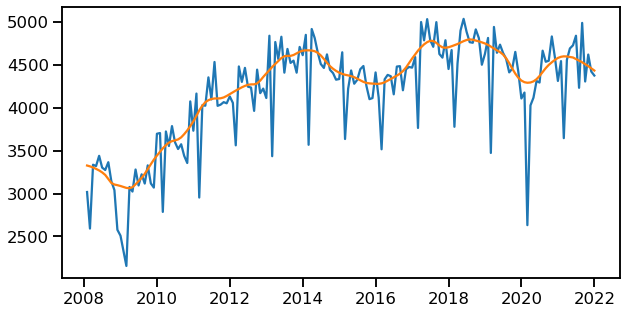

In [72]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(df_train.index, df_train['cargo'], label='cargo')
ax.plot(df_train.index, df_train['lowess'],label='lowess_trend')

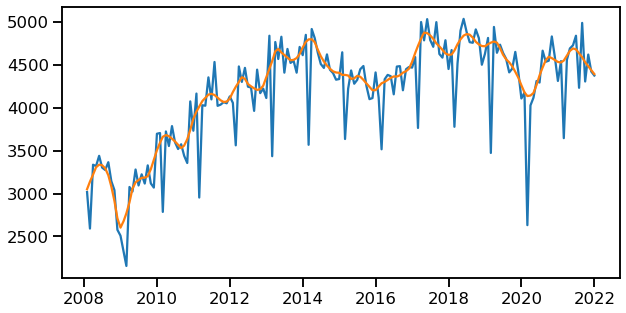

In [73]:
# frac 0.05 일때
frac = 0.05
res = lowess(
        endog=y,
        exog=x,
        frac = frac,
        it=3)
df_train['lowess'] = res[:,1]

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(df_train.index, df_train['cargo'], label='cargo')
ax.plot(df_train.index, df_train['lowess'],label='lowess_trend')

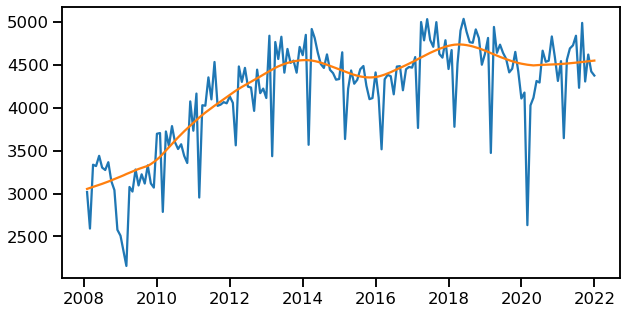

In [74]:
# frac 0.2 일때
frac = 0.25
res = lowess(
        endog=y,
        exog=x,
        frac = frac,
        it=3)
df_train['lowess'] = res[:,1]

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(df_train.index, df_train['cargo'], label='cargo')
ax.plot(df_train.index, df_train['lowess'],label='lowess_trend')

In [75]:
from scipy.signal import argrelextrema
local_max_points = argrelextrema(np.array(df_train['lowess']), np.greater)[0]
print(f"local_max points: {local_max_points}")

local_min_points = argrelextrema(np.array(df_train['lowess']), np.less)[0]
print(f"local_min points: {local_min_points}")

local_max points: [ 72 123]
local_min points: [ 93 147]


In [76]:
change_points = np.concatenate([local_max_points,local_min_points])

Change points: 2014-01-31 00:00:00
Change points: 2018-04-30 00:00:00
Change points: 2015-10-31 00:00:00
Change points: 2020-04-30 00:00:00


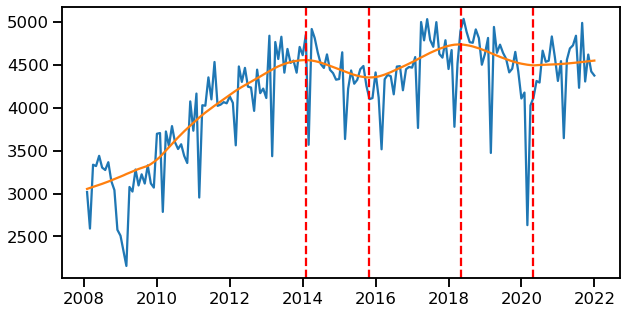

In [77]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(df_train.index, df_train['cargo'], label='cargo')
ax.plot(df_train.index, df_train['lowess'],label='lowess_trend')
 
for points in change_points:
    ax.axvline(x= df_train.index[points], ls='--', color="r")
    c_date = df_train.index[points]
    print(f"Change points: {c_date}")

## Trial2: rolling
* 이동평균의 경우 이상치에 영향을 받아 조금 더 쉽게 change point를 찾을 수 있을 것이라 생각
* window 를 바꿔주면서 가장 잘 나타내는 점을 찾아보려함

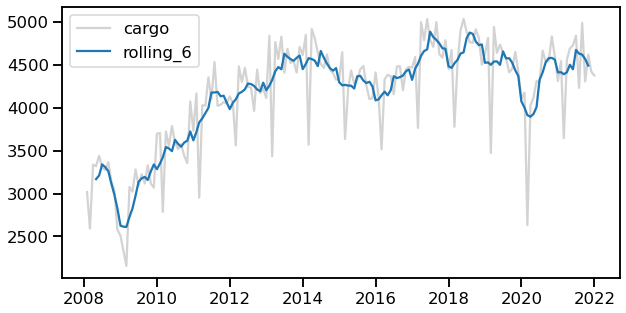

In [78]:
window = 6
df_rolling = df_train.rolling(window=window,center=True).mean()

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(df_train.index, df_train['cargo'], label='cargo',color='lightgray')
ax.plot(df_rolling.index, df_rolling['cargo'], label=f'rolling_{window}')
ax.legend()

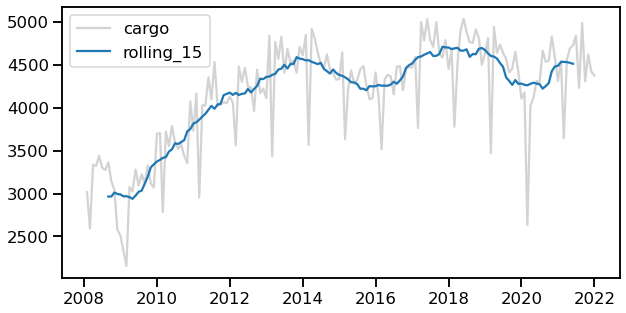

In [79]:
window = 15
df_rolling = df_train.rolling(window=window,center=True).mean()

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(df_train.index, df_train['cargo'], label='cargo',color='lightgray')
ax.plot(df_rolling.index, df_rolling['cargo'], label=f'rolling_{window}')
ax.legend()

In [80]:
from scipy.signal import argrelextrema
local_max_points = argrelextrema(np.array(df_rolling['cargo']), np.greater)[0]
print(f"local_max points: {local_max_points}")

local_min_points = argrelextrema(np.array(df_rolling['cargo']), np.less)[0]
print(f"local_min points: {local_min_points}")

local_max points: [  9  13  29  41  47  49  53  57  65  67  69  73  77  81  93  96 101 113
 117 122 125 127 130 141 143 147 157]
local_min points: [ 12  15  30  42  48  50  54  58  66  68  72  76  80  92  94  99 102 114
 120 123 126 128 140 142 145 150]


<AxesSubplot:>

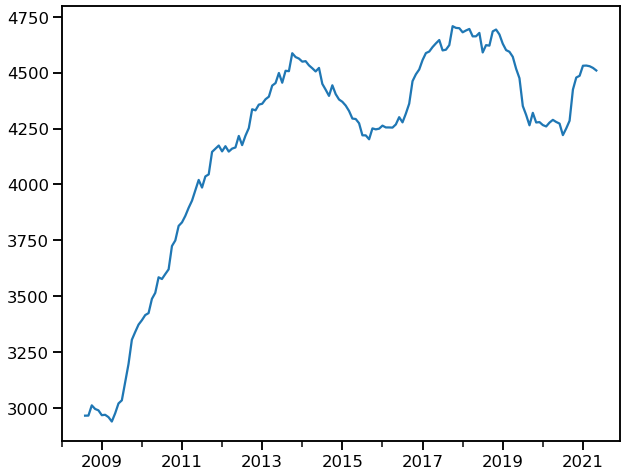

In [81]:
df_rolling['cargo'].plot()

<AxesSubplot:>

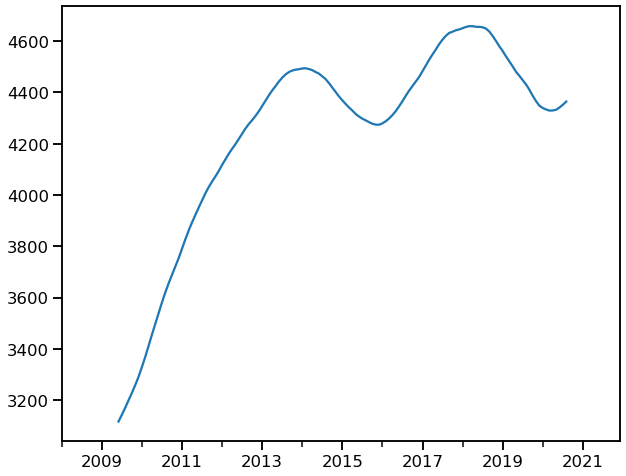

In [85]:
# re-smoothing
df_rolling2 = df_rolling['cargo'].rolling(window=20,center=True).mean()
df_rolling2.plot()

In [86]:
local_max_points = argrelextrema(np.array(df_rolling2), np.greater)[0]
print(f"local_max points: {local_max_points}")

local_min_points = argrelextrema(np.array(df_rolling2), np.less)[0]
print(f"local_min points: {local_min_points}")

local_max points: [ 73 122]
local_min points: [ 95 146]


Change points: 2014-02-28 00:00:00
Change points: 2018-03-31 00:00:00
Change points: 2015-12-31 00:00:00
Change points: 2020-03-31 00:00:00


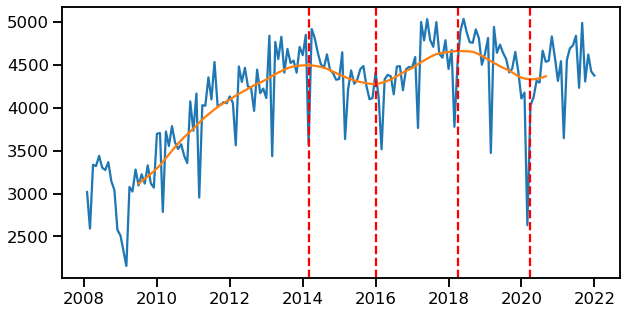

In [87]:
change_points = np.concatenate([local_max_points,local_min_points])
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(df_train.index, df_train['cargo'], label='cargo')
ax.plot(df_rolling2.index, df_rolling2,label='lowess_trend')
 
for points in change_points:
    ax.axvline(x= df_train.index[points], ls='--', color="r")
    c_date = df_train.index[points]
    print(f"Change points: {c_date}")

In [88]:
# 마지막 추세변환점 직접 찾기
# 2020년 2월 급격한 감소
df_train.loc['2020']['cargo']

2020-01-31    4175.0
2020-02-29    2631.9
2020-03-31    4025.6
2020-04-30    4115.0
2020-05-31    4309.6
2020-06-30    4291.6
2020-07-31    4662.2
2020-08-31    4533.3
2020-09-30    4545.4
2020-10-31    4828.0
2020-11-30    4591.4
2020-12-31    4310.3
Name: cargo, dtype: float64

## Change point detection 시도결과
* trend의 증가 감소는 잡을 수 있지만 같은 추세에서 기울기 변화는 잡을 수 없는 한계가 있음
* lowess의 경우 이상치에 robust 한 성질이 있어 추세변화점을 잡기에 좋지 않았음
* local min, local max가 잘 나오게 조절하려면 frac을 사람이 조절해줘야 하는 문제점이 있음

* rolling의 경우 변화가 크게 있어 포인트 잡기는 좋았음
* 하지만 밀리는 점, 가장 중요한 끝부분에서 잡히지 않는 점 등에서 문제
자동화 모델을 구축하기엔 한계가 있음-> 추후 논문을 보고 구현해볼 계획

 # Modeling2(+trend feature)
 2022년부터 코로나 회복세로 다시 꾸준히 화물량이 증가한다는 가정
 2022년 4월 상하이항 봉쇄

In [94]:
change_dates = []
for points in change_points:
    c_date = df_total.index[points]
    change_dates.append(c_date)
    
# 시작점
change_dates.append(df_total.index[0])
change_dates.append(pd.to_datetime('2020-02-29'))
change_dates

[Timestamp('2014-02-28 00:00:00'),
 Timestamp('2018-03-31 00:00:00'),
 Timestamp('2015-12-31 00:00:00'),
 Timestamp('2020-03-31 00:00:00'),
 Timestamp('2008-01-31 00:00:00'),
 Timestamp('2020-02-29 00:00:00')]

In [95]:
for date in change_dates:
    time_diff = df_total.index - date
    df_total[f'time_since_{date}'] = np.round(time_diff/np.timedelta64(1,"M"))
    df_total[f'time_since_{date}'] = df_total[f'time_since_{date}'].clip(0)

In [96]:
df_total

,cargo,month_sin,month_cos,lag_1,lag_2,lag_4,lag_12,time_since_2014-02-28 00:00:00,time_since_2018-03-31 00:00:00,time_since_2015-12-31 00:00:00,time_since_2020-03-31 00:00:00,time_since_2008-01-31 00:00:00,time_since_2020-02-29 00:00:00
2008-01-31,3017.4,5.000000e-01,8.660254e-01,3098.5,2964.1,2909.9,2828.2,0.0,0.0,0.0,0.0,0.0,0.0
2008-02-29,2592.2,8.660254e-01,5.000000e-01,3017.4,3098.5,2918.6,2512.5,0.0,0.0,0.0,0.0,1.0,0.0
2008-03-31,3335.0,1.000000e+00,6.123234e-17,2592.2,3017.4,2964.1,2850.2,0.0,0.0,0.0,0.0,2.0,0.0
2008-04-30,3319.4,8.660254e-01,-5.000000e-01,3335.0,2592.2,3098.5,3027.7,0.0,0.0,0.0,0.0,3.0,0.0
2008-05-31,3438.6,5.000000e-01,-8.660254e-01,3319.4,3335.0,3017.4,3139.4,0.0,0.0,0.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-31,4394.4,-8.660254e-01,5.000000e-01,4194.7,4566.3,4017.0,4617.2,104.0,55.0,82.0,31.0,177.0,32.0
2022-11-30,4529.5,-5.000000e-01,8.660254e-01,4394.4,4194.7,4810.2,4420.3,105.0,56.0,83.0,32.0,178.0,33.0
2022-12-31,4566.1,-2.449294e-16,1.000000e+00,4529.5,4394.4,4566.3,4373.0,106.0,57.0,84.0,33.0,179.0,34.0
2023-01-31,4304.7,5.000000e-01,8.660254e-01,4566.1,4529.5,4194.7,4773.4,107.0,58.0,85.0,34.0,180.0,35.0


In [92]:
df_train = df_Train.loc[:'2020']
df_valid = df_Train.loc['2021']

X_train = df_train.drop(columns='cargo').copy()
y_train = df_train['cargo']

X_valid = df_valid.drop(columns='cargo').copy()
y_valid = df_valid['cargo']

In [93]:
model = LinearRegression()
model.fit(X_train,y_train)

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

fig, ax = plt.subplots(figsize=(10,5),constrained_layout=True)
ax.plot(df_total.index, df_total['cargo'], c='lightgray')
ax.plot(df_train.index, train_preds, lw=1.5, label='train')
ax.plot(df_test.index, test_preds, lw=1.5, label='test')

# train, valid 구분선
ax.axvline(x=df_train.index[-1], ls='--')
ax.legend()

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- lag_1
- lag_12
- lag_2
- lag_4
- month_cos
- ...
Feature names seen at fit time, yet now missing:
- month
- time_since_2007-01-31 00:00:00
- time_since_2013-02-28 00:00:00
- time_since_2014-12-31 00:00:00
- time_since_2017-03-31 00:00:00
- ...
